# HW2 for CS 135 in Fall 2025

Instructions:
<https://www.cs.tufts.edu/cs/135/2025s/hw2.html>

Instructions on webpage should be considered *authoritative*. Any instructions here in this notebook are provided to be extra helpful, but when in doubt follow the webpage instructions.

This notebook is specifically for the report related to Problem 1.

# Problem 1: Binary Classifier for Cancer-Risk Screening 

### Prereq

* You will need to finish **Code Task** for **Problem 1** before working on this notebook. 

### Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd

import sklearn.linear_model
import sklearn.metrics

In [3]:
# Plotting libraries
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', style='whitegrid', font_scale=1.25)

# Autoload changes in other files.
# Avoids restarting the Jupyter kernel each time you make a change to the imported code.
%load_ext autoreload
%autoreload 2

# Import student-edited code 

Remember, you should have *completed* the Code Tasks for Problem 1 first.

In [4]:
if not os.path.exists('binary_metrics.py'):
    raise ImportError("CANNOT FIND binary_metrics.py. Make sure you run this notebook in same directory as your .py files.")

In [5]:
from binary_metrics import (
    calc_ACC, calc_TPR, calc_TNR)

# Import helper code (will work as provided, no edits needed)

In [6]:
import threshold_selection

In [7]:
from confusion_matrix import calc_confusion_matrix_for_probas_and_threshold

# Provided function for computing mean binary cross entropy

Here, we provide a *completed* function you can use as is for Problem 1 report.

Later in Problem 2, you'll write your own version of this function without using sklearn.

Remember, we want the *base-2* cross entropy. For *one* pair of true label $y$ and predicted proba $p$, we have

$$
BCE(y, p) = - y \log_2 p - (1-y) \log_2(1-p)
$$

The function below computes the mean of this BCE across a whole dataset of size N

In [8]:
def calc_mean_BCE_from_probas(ytrue_N, yproba1_N):
    ''' Compute mean binary cross entropy
    
    Args
    ----
    ytrue_N : 1D array, size (n_examples,) = (N,)
    yproba1_N : 1D array, size (n_examples,) = (N,)
    
    Returns
    -------
    mean_bce : float
        mean binary cross entropy across all N examples
    '''
    return sklearn.metrics.log_loss(ytrue_N, yproba1_N, labels=[0,1]) / np.log(2.0)

In [9]:
# Check that BCE loss is high if true class is 1 but probability is low
calc_mean_BCE_from_probas([1.], [0.01])

6.643856189774724

In [10]:
# Check that BCE loss is exactly 1 if true class is 1 but probability is 0.5
calc_mean_BCE_from_probas([1.], [0.5])

1.0

In [11]:
# Check that BCE loss is close to zero if true class is 1 but probability is 0.99
calc_mean_BCE_from_probas([1.], [0.99])

0.01449956969511509

# Load x and y array data for problem 1

In [12]:
def load_x(csv_path, feat_names=['age_0to1', 'famhistory', 'marker_0to1']):
    df = pd.read_csv(csv_path, usecols=feat_names)
    return np.asarray(df.values, dtype=np.float64)

In [13]:
def load_y(csv_path, col_name='cancer'):
    df = pd.read_csv(csv_path, usecols=[col_name])
    return np.asarray(df.values, dtype=np.float64).flatten()

In [14]:
# Make sure you have downloaded data and your directory is correct
DATA_DIR = os.path.join('data_cancer') 

In [15]:
# Load 3 feature version of x arrays
x_tr_M3 = load_x(os.path.join(DATA_DIR, 'x_train.csv'))
x_va_N3 = load_x(os.path.join(DATA_DIR, 'x_valid.csv'))
x_te_N3 = load_x(os.path.join(DATA_DIR, 'x_test.csv'))

for label, x in [('train', x_tr_M3), ('valid', x_va_N3), ('test', x_te_N3)]:
    print("Loaded x_%-5s : shape %s" % (label, x.shape))

Loaded x_train : shape (390, 3)
Loaded x_valid : shape (180, 3)
Loaded x_test  : shape (180, 3)


In [16]:
# Load 2 feature version of x arrays
x_tr_M2 = x_tr_M3[:, :2].copy()
x_va_N2 = x_va_N3[:, :2].copy()
x_te_N2 = x_te_N3[:, :2].copy()

In [17]:
N_shape = x_va_N3.shape
M_shape = x_tr_M3.shape

N = N_shape[0]
M = M_shape[0]

**TODO** : Load outcomes **y** arrays

In [18]:
# Load outcomes y arrays
y_tr_M = load_y(os.path.join(DATA_DIR, 'y_train.csv'))
assert y_tr_M.ndim == 1
assert y_tr_M.shape[0] == x_tr_M2.shape[0]

# Hint: Use the load_y helper, as we did for load_x above
y_va_N = load_y(os.path.join(DATA_DIR, "y_valid.csv"))
y_te_N = load_y(os.path.join(DATA_DIR, "y_test.csv"))
assert y_va_N.ndim == 1
assert y_va_N.shape[0] == x_va_N2.shape[0]
assert y_va_N.shape[0] == y_te_N.shape[0]

## Step 1A: Data Summarization

### Table 1 for Report

Provide a table summarizing some basic properties of the provided training set, validation set, and test set:

* Row 1 'total count': how many total examples are in each set?
* Row 2 'positive label count': how many examples have a positive label (means cancer)?
* Row 3 'fraction positive' : what fraction (between 0 and 1) of the examples have cancer?

Your result should be 3 by 3 containing 'total count', 'positive label count' and 'fraction positive' of training, valid and test sets. An example of the output looks like this:

|                               | train  |valid    |test|
|:-|-:|-:|-:|
|num. total examples            |560.000  |120.000  |120.000
|num. positive examples         |56.000   |12.000   |12.000
|fraction of positive examples  |0.100    |0.100    |0.100

All results should **keep 3 digits**. We set a pandas display option to ensure that below.

**TODO**: make a pandas dataframe with the correct data properties

In [19]:
train_1 = np.count_nonzero(y_tr_M)
train_0 = M - train_1

valid_1 = np.count_nonzero(y_va_N)
valid_0 = N - valid_1

test_1 = np.count_nonzero(y_te_N)
test_0 = N - test_1

In [20]:
table1_df = pd.DataFrame(dict(train=[M,train_1,train_1 / M], valid=[N,valid_1,valid_1 / N], test=[N,test_1,test_1 / N]))
table1_df.index = ['num. total examples', 'num. positive examples', 'fraction of positive examples']

**TODO:** Use pandas' built in printing to make a nice table (using a fixed-width font)

In [21]:
pd.set_option('display.precision', 3) # Keep this, so 3 digits after decimal are printed
print(table1_df)
# print(table1_df.to_latex(float_format="%.3f"))

                                 train    valid     test
num. total examples            390.000  180.000  180.000
num. positive examples          55.000   25.000   25.000
fraction of positive examples    0.141    0.139    0.139


##  Step 1B: The predict-0-always baseline

**TODO**: predict zero for all test data points

In [22]:
baseline_yhat_te_N = np.zeros(N)
print(baseline_yhat_te_N)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [23]:
print(y_te_N)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [24]:
print(calc_confusion_matrix_for_probas_and_threshold(y_te_N, baseline_yhat_te_N, 0.5))

Predicted    0  1
True             
0          155  0
1           25  0


**TODO** Use the printed information from the previous code cell to calculate the accuracy of baseline. 

Keep 3 digits in your PDF report for short Answer 1a.

In [25]:
baseline_acc = ( 155 + 0 ) / 180
print("Baseline has accuracy: ", baseline_acc)

Baseline has accuracy:  0.8611111111111112


### Short Answer 1a in Report

*See instructions on website*

## Step 1C : Logistic Regression with F=2 dataset

**TODO**: Complete each line marked TODO fixme in the codeblock below

In [26]:
C_grid = np.logspace(-4, 4, 17)

# We will fit a separate logistic regression for each C value in the C_grid
# And store that classifier's performance metrics (lower is better)
# So we can compare and select the best C in the future steps.

modelF2_list = list()

# Allocate lists for storing BCE metrics
tr_bce_list = list()
va_bce_list = list()
te_bce_list = list()

# Allocate lists for storing ERROR RATE metrics
tr_err_list = list()
va_err_list = list()
te_err_list = list()

# Remember, we justified BCE for training our classifier by saying
# it provides an *upper bound* on the error rate.

# Loop over C values, fit models, record metrics
for C in C_grid:
    # TODO: Follow the instruction in HW2 and train the model lr_F2
    # Part a: Initialize a LogisticRegression classifier with desired C value
    # Part b: train the model with the 2-feature dataset
    lrF2 = sklearn.linear_model.LogisticRegression(solver='lbfgs', C=C)
    lrF2.fit(x_tr_M2, y_tr_M)
    
    modelF2_list.append(lrF2)
    
    yproba1_tr_M = lrF2.predict_proba(x_tr_M2)[:,1] # The probability of class 1 on the training set
    yproba1_va_N = lrF2.predict_proba(x_va_N2)[:,1] # The probability of class 1 on the validation set
    
    # Compute error rate aka zero-one loss
    my_tr_err = sklearn.metrics.zero_one_loss(y_tr_M, yproba1_tr_M >= 0.5)
    my_va_err = sklearn.metrics.zero_one_loss(y_va_N, yproba1_va_N >= 0.5)
    tr_err_list.append(my_tr_err)
    va_err_list.append(my_va_err)
    
    # use calc_mean_BCE_from_probas function defined above.
    my_tr_bce = calc_mean_BCE_from_probas(y_tr_M, yproba1_tr_M)
    my_va_bce = calc_mean_BCE_from_probas(y_va_N, yproba1_va_N)
    # Save bce for future selection
    tr_bce_list.append(my_tr_bce) 
    va_bce_list.append(my_va_bce) 

Make plot to visualize mean BCE and ERR over C values (internal debugging only)

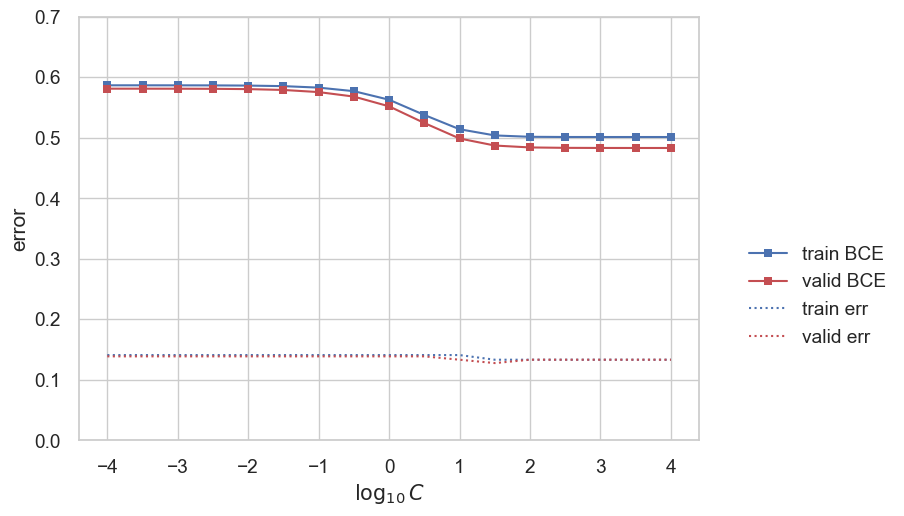

In [27]:
plt.plot(np.log10(C_grid), tr_bce_list, 'bs-', label='train BCE')
plt.plot(np.log10(C_grid), va_bce_list, 'rs-', label='valid BCE')

plt.plot(np.log10(C_grid), tr_err_list, 'b:', label='train err')
plt.plot(np.log10(C_grid), va_err_list, 'r:', label='valid err')

plt.ylabel('error')
plt.xlabel("$\log_{10} C$");
plt.legend(bbox_to_anchor=(1.33, 0.5)) # make legend outside plot
plt.ylim([0, 0.7]);

In [28]:
print("Searched over these C values:")
print(C_grid)

print("Recorded these BCE loss values on val set")
print(va_bce_list)

Searched over these C values:
[1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02 3.16227766e+02 1.00000000e+03 3.16227766e+03
 1.00000000e+04]
Recorded these BCE loss values on val set
[0.5813426351401082, 0.5813254320139232, 0.5812733119651239, 0.581111409940575, 0.5806176186139597, 0.5792270655407633, 0.5757056797162877, 0.5682723190563558, 0.5521275371476653, 0.5245937808237384, 0.4989979983514493, 0.4873552639106167, 0.48422067427118154, 0.4835408718221729, 0.48336529559307057, 0.483315660426351, 0.4833090534387383]


**TODO** Find the best C with the samllest cross entropy loss on the validation set.

In [29]:
# Find the C that corresponds to the smallest BCE loss on the validation set
min_idx = np.argmin(va_bce_list)
print(va_bce_list[min_idx])
best_C__lrF2 = C_grid[min_idx] 

print("Best C value for F2 model:")
print(best_C__lrF2)

0.4833090534387383
Best C value for F2 model:
10000.0


**TODO** Load the model that was rated 'best'

In [30]:
best_lrF2 = modelF2_list[min_idx] 

print("Best model has coefficient values:")
print(best_lrF2.coef_)

Best model has coefficient values:
[[17.30194606  0.72291375]]


In [31]:
# Output the prediction of your best model for 2-feature data on the training, valid, and test set. 
# Return the probability of predicting positive class
# We'll use them for the ROC curve later.

bestlrF2_yproba1_tr_M = best_lrF2.predict_proba(x_tr_M2)[:,1]
bestlrF2_yproba1_va_N = best_lrF2.predict_proba(x_va_N2)[:,1]
bestlrF2_yproba1_te_N = best_lrF2.predict_proba(x_te_N2)[:,1]

# Remember: predict_proba returns a 2D array with TWO columns
# we use [:, 1] to grab the second column, corresponding to the positive class
# the first column is the probability of the negative class (no cancer)

## Step 1D : Logistic Regression with F=3 dataset
**TODO**: 
* Repeat Step 1C for 3-feature dataset to find the best C. Use same C_grid and same way to pick best on val set.
* Copy that block of code from above here, and modify accordingly...

In [32]:
# codeblock that fits model for each C and measures error
C_grid = np.logspace(-4, 4, 17)

# We will fit a separate logistic regression for each C value in the C_grid
# And store that classifier's performance metrics (lower is better)
# So we can compare and select the best C in the future steps.

modelF3_list = list()

# Allocate lists for storing BCE metrics
tr3_bce_list = list()
va3_bce_list = list()
te3_bce_list = list()

# Allocate lists for storing ERROR RATE metrics
tr3_err_list = list()
va3_err_list = list()
te3_err_list = list()

# Remember, we justified BCE for training our classifier by saying
# it provides an *upper bound* on the error rate.

# Loop over C values, fit models, record metrics
for C in C_grid:
    # Follow the instruction in HW2 and train the model lr_F2
    # Part a: Initialize a LogisticRegression classifier with desired C value
    # Part b: train the model with the 3-feature dataset
    lrF3 = sklearn.linear_model.LogisticRegression(solver='lbfgs', C=C)
    lrF3.fit(x_tr_M3, y_tr_M)
    
    modelF3_list.append(lrF3)
    
    yproba1_tr_M = lrF3.predict_proba(x_tr_M3)[:,1] # The probability of class 1 on the training set
    yproba1_va_N = lrF3.predict_proba(x_va_N3)[:,1] # The probability of class 1 on the validation set
    
    # Compute error rate aka zero-one loss
    my_tr_err = sklearn.metrics.zero_one_loss(y_tr_M, yproba1_tr_M >= 0.5)
    my_va_err = sklearn.metrics.zero_one_loss(y_va_N, yproba1_va_N >= 0.5)
    tr3_err_list.append(my_tr_err)
    va3_err_list.append(my_va_err)
    
    # use calc_mean_BCE_from_probas function defined above.
    my_tr_bce = calc_mean_BCE_from_probas(y_tr_M, yproba1_tr_M)
    my_va_bce = calc_mean_BCE_from_probas(y_va_N, yproba1_va_N)
    # Save bce for future selection
    tr3_bce_list.append(my_tr_bce) 
    va3_bce_list.append(my_va_bce) 

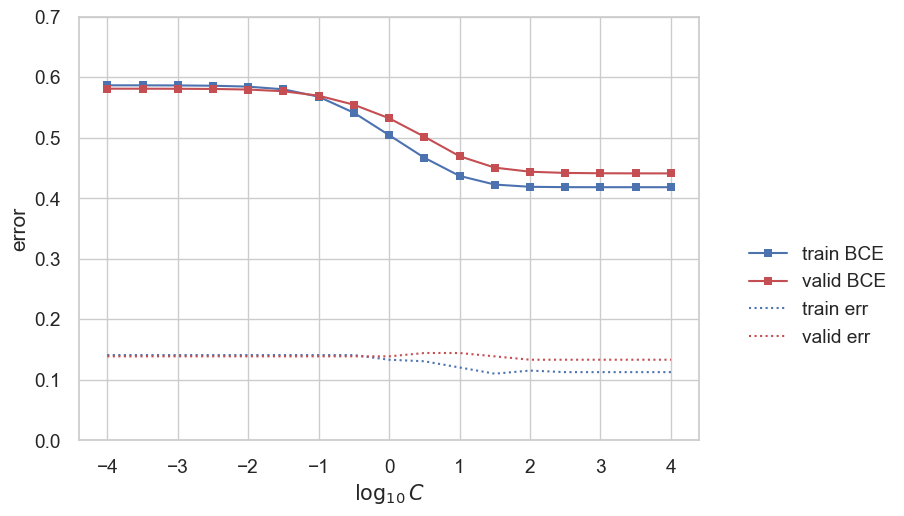

In [33]:
# TODO codeblock that visualizes error as function of C (for your own debugging
# purposes)
plt.plot(np.log10(C_grid), tr3_bce_list, 'bs-', label='train BCE')
plt.plot(np.log10(C_grid), va3_bce_list, 'rs-', label='valid BCE')

plt.plot(np.log10(C_grid), tr3_err_list, 'b:', label='train err')
plt.plot(np.log10(C_grid), va3_err_list, 'r:', label='valid err')

plt.ylabel('error')
plt.xlabel("$\log_{10} C$");
plt.legend(bbox_to_anchor=(1.33, 0.5)) # make legend outside plot
plt.ylim([0, 0.7]);

In [34]:
# codeblock that finds the best C value and corresponding best LR model
print("Searched over these C values:")
print(C_grid)

print("Recorded these BCE loss values on val set")
print(va3_bce_list)
# Find the C that corresponds to the smallest BCE loss on the validation set
min_idx = np.argmin(va3_bce_list)
print(va3_bce_list[min_idx])
best_C__lrF3 = C_grid[min_idx] 

print("Best C value for F3 model:")
print(best_C__lrF3)

Searched over these C values:
[1.00000000e-04 3.16227766e-04 1.00000000e-03 3.16227766e-03
 1.00000000e-02 3.16227766e-02 1.00000000e-01 3.16227766e-01
 1.00000000e+00 3.16227766e+00 1.00000000e+01 3.16227766e+01
 1.00000000e+02 3.16227766e+02 1.00000000e+03 3.16227766e+03
 1.00000000e+04]
Recorded these BCE loss values on val set
[0.5813347461367306, 0.5813024291848665, 0.5812012369110466, 0.5808846844085777, 0.5799102632966531, 0.5770682188282334, 0.5697643397177846, 0.5548231567919828, 0.532473893553105, 0.5019849699409503, 0.4697251827756534, 0.45085095771541134, 0.4440701858272876, 0.44210035041274925, 0.44152915505092794, 0.4413557080161287, 0.44130165778977]
0.44130165778977
Best C value for F3 model:
10000.0


**TODO**:
* Using your best F=3 model, predict the probability of predicting positive class (y=1) on training, validation and test set.

In [35]:
best_lrF3 = modelF3_list[min_idx]

print("Best model has coefficient values:")
print(best_lrF3.coef_)

# Return the posibility of predicting true on training, validation and test set.
# Hint: follow what's done in the last code block of Step 1C.

bestlrF3_yproba1_tr_M = best_lrF3.predict_proba(x_tr_M3)[:,1]
bestlrF3_yproba1_va_N = best_lrF3.predict_proba(x_va_N3)[:,1]
bestlrF3_yproba1_te_N = best_lrF3.predict_proba(x_te_N3)[:,1]

Best model has coefficient values:
[[20.00604772  0.7806252   7.17378657]]


## Step 1E : Comparing Models using ROC Analysis


**TODO**:

1) Review the sklearn documentation for using [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)

2) Skim the sklearn User Guide on [ROC curves](https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics)

3) Follow instructions below to produce a ROC figure for your report

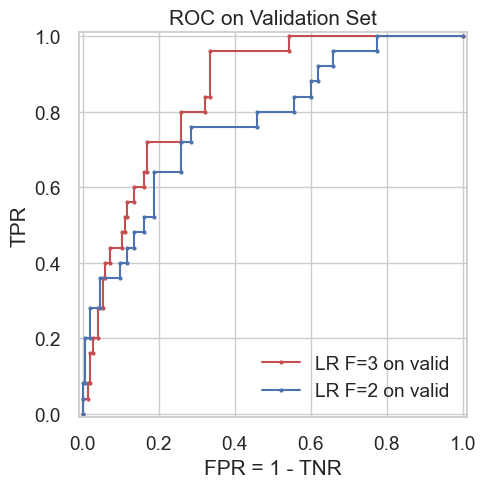

In [36]:
# ROC curve comparing F=2 and F=3 logistic regression (LR) models

# Create square aspect-ratio figure
plt.subplots(nrows=1, ncols=1, figsize=(5,5));

# TODO Use provided true labels and predictions for validation set
# Call `sklearn.metrics.roc_curve'. See links above to User Guide and docs.
# This will produce arrays of fpr (false pos rate) and tpr (true pos rate) values,
# That you can use to make the ROC plot, replacing the dummy fpr/tpr values below.

# Read HW2 instructions carefully to verify correct plot style (line type, line color, etc.)

fpr, tpr, t1 = sklearn.metrics.roc_curve(y_va_N, bestlrF3_yproba1_va_N)
plt.plot(fpr, tpr, 'r.-', label='LR F=3 on valid');

fpr, tpr, t2 = sklearn.metrics.roc_curve(y_va_N, bestlrF2_yproba1_va_N)
plt.plot(fpr, tpr, 'b.-', label='LR F=2 on valid');

# print(t2)
# print(t1)

plt.title("ROC on Validation Set");
plt.xlabel('FPR = 1 - TNR');
plt.ylabel('TPR');
plt.legend(loc='lower right');
B = 0.01
plt.xlim([0 - B, 1 + B]);
plt.ylim([0 - B, 1 + B]);

### Figure 1 for Report: Comparing models using ROC analysis

**TODO**: *Include the above figure in your report*.

### Short Answer 1b for Report

*See instructions on website*

## Selecting a decision threshold

Remember that to turn predicted probabilities into binary decisions, we need a threshold.

Steps 1F and 1G describe two ways to pick such a threshold.

**Best Practice throughout**: Pick threshold on validation set. Measure ultimate performance on test set.

## Step 1F: Use F=3 LR with threshold = 0.5

In [37]:
default_thr = 0.5

# calculate Confusion Matrix for this threshold
cmat_df = calc_confusion_matrix_for_probas_and_threshold(y_va_N, bestlrF3_yproba1_va_N, default_thr)
# See previous usage in Step 1B above


# compute True Positive Rate (TPR)
# we want 
tpr = calc_TPR(y_va_N, bestlrF3_yproba1_va_N >= default_thr)

# compute True Negative Rate (TNR)
tnr = calc_TNR(y_va_N, bestlrF3_yproba1_va_N >= default_thr)

print(f"Fig. 2 column 1:\n\nthreshold = {default_thr :.3f}\n")
print(cmat_df)
print(f"\nTPR = {tpr :.3f}\nTNR = {tnr :.3f}")

Fig. 2 column 1:

threshold = 0.500

Predicted    0  1
True             
0          152  3
1           21  4

TPR = 0.160
TNR = 0.981


## Step 1G : Use F=3 LR with threshold to maximize TNR s.t. TPR >= 0.95

In [38]:
# Compute performance metrics across possible thresholds from 0.0 to 1.0
# Here, we're looking at VALIDATION set

thresh_grid, va_perf_grid = threshold_selection.compute_perf_metrics_across_thresholds(
    y_va_N, bestlrF3_yproba1_va_N)

In [39]:
# Inspect what the above returned...

# thresh_grid is a big 1D array of possible thresholds
# va_perf_grid is a dict, where each key gives a 1D array same size as thresh_grid

# See only the first 3 entries
for gg in range(3):
    print('thr', thresh_grid[gg])
    print('ACC', va_perf_grid['acc'][gg])
    print('TPR', va_perf_grid['tpr'][gg])
    print('TNR', va_perf_grid['tnr'][gg])
    print()
print("...")

thr 0.0
ACC 0.13888888888881173
TPR 0.9999999999960001
TNR 0.0

thr 0.0006245136199418165
ACC 0.13888888888881173
TPR 0.9999999999960001
TNR 0.0

thr 0.0012832922108336694
ACC 0.14444444444436422
TPR 0.9999999999960001
TNR 0.006451612903221645

...


**TODO**: Write code to find the threshold that maximizes TNR while TPR >= 0.95

In [40]:
# Find threshold that makes TNR as large as possible, while satisfying TPR >=
# 0.95
best_gg = 0

good_TPR = va_perf_grid['tpr'] >= 0.95
filtered_thresholds = thresh_grid[good_TPR]
filtered_TNR = va_perf_grid['tnr'][good_TPR]
filtered_TPR = va_perf_grid['tpr'][good_TPR]
for gg in range(len(filtered_thresholds)):
    if (filtered_TNR[gg] == filtered_TNR[best_gg] and 
        filtered_TNR[gg] > filtered_TNR[best_gg]):
        best_gg = gg
    elif filtered_TNR[gg] > filtered_TNR[best_gg]:
        best_gg = gg

print(best_gg)
# print("TNR")
# print(filtered_TNR)
# print(va_perf_grid['tnr'])
# print("TPR")
# print(filtered_TPR)
# print(va_perf_grid['tpr'])

# print(thresh_grid)
# print(filtered_thresholds)

# Make arrays for threshold, TPR, and TNR
# Make smaller arrays such that all entries satisfy the TPR constraint
# Search for the largest TNR value, and keep corresponding threshold

best_thr = filtered_thresholds[best_gg]
print(best_thr)

105
0.07547371472100284


In [41]:
# calculate Confusion Matrix for this threshold
# ___ = calc_confusion_matrix_for_probas_and_threshold(___)
# See previous usage in Step 1B above
cmat_df = calc_confusion_matrix_for_probas_and_threshold(y_va_N, bestlrF3_yproba1_va_N, best_thr)

# compute True Positive Rate (TPR)
tpr = calc_TPR(y_va_N, bestlrF3_yproba1_va_N >= best_thr)

# compute True Negative Rate (TNR)
tnr = calc_TNR(y_va_N, bestlrF3_yproba1_va_N >= best_thr)


print(f"Fig. 2 column 2:\n\nthreshold = {best_thr :.3f}\n")
print(cmat_df)
print(f"\nTPR = {tpr :.3f}\nTNR = {tnr :.3f}")

Fig. 2 column 2:

threshold = 0.075

Predicted    0   1
True              
0          103  52
1            1  24

TPR = 0.960
TNR = 0.665


### Table 2 for Report

See instructions on website on how to combine material from Step 1F and Step 1G
to produce a table.


Each column should correspond to one of the following models:

* F=3 Logistic Regression using threshold 0.5 from 1F
* F=3 Logistic Regression using selected threshold from 1G

Each row should report the performance of the model on the test set

* Top: Threshold
* Middle: confusion matrix on the test set
* Bottom: TPR and TNR on the test set




In [ ]:
cmat_test__default = calc_confusion_matrix_for_probas_and_threshold(y_te_N, bestlrF3_yproba1_te_N, default_thr)
cmat_test__best    = calc_confusion_matrix_for_probas_and_threshold(y_te_N, bestlrF3_yproba1_te_N, best_thr)

TPR__default, TNR__default = calc_TPR(y_te_N, bestlrF3_yproba1_te_N >= default_thr), calc_TNR(y_te_N, bestlrF3_yproba1_te_N >= default_thr)
TPR__best, TNR__best       = calc_TPR(y_te_N, bestlrF3_yproba1_te_N >= best_thr), calc_TNR(y_te_N, bestlrF3_yproba1_te_N >= best_thr)

df1  = pd.DataFrame(cmat_test__default).to_latex()
df2  = pd.DataFrame(cmat_test__best).to_latex()

print(df1)
print()
print(df2)
col_names = ['F=3 Logistic Regression with Default Threshold', 'F=3 Logistic Regression with Best Threshold']
row_names = ['Threshold used.', 'Confusion Matrix on test set.', 'TPR and TNR on the test set']
df = pd.DataFrame(columns=col_names, 
             index=row_names, 
             data=[
                 [f'{default_thr : .3f}', f'{best_thr : .3f}'], 
                 [cmat_test__default, cmat_test__best], [
                     f"TPR = {TPR__default : .3f} TNR = {TNR__default : .3f}",
                        f"TPR = {TPR__best : .3f} TNR = {TNR__best : .3f}"]])
df
print(92/180 * 1000, 1/180 * 1000, 63/180 * 1000, 24/180 * 1000)

pd.DataFrame([])
sum([92/180 * 1000, 1/180 * 1000, 63/180 * 1000, 24/180 * 1000])

\begin{tabular}{lrr}
\toprule
Predicted & 0 & 1 \\
True &  &  \\
\midrule
0 & 149 & 6 \\
1 & 17 & 8 \\
\bottomrule
\end{tabular}


\begin{tabular}{lrr}
\toprule
Predicted & 0 & 1 \\
True &  &  \\
\midrule
0 & 92 & 63 \\
1 & 1 & 24 \\
\bottomrule
\end{tabular}

511.1111111111111 5.555555555555555 350.0 133.33333333333334


1000.0

### Short Answer 1c and 1d for Report

*See instructions on website*

In [76]:
# for short answer 1e
cm = [[92/180 * 1000, 1/180 * 1000], [63/180 * 1000, 24/180 * 1000]]
cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
cm_df.columns.name = 'Predicted'
cm_df.index.name = 'True'
print(cm_df.to_latex())

\begin{tabular}{lrr}
\toprule
Predicted & 0 & 1 \\
True &  &  \\
\midrule
0 & 511.111111 & 5.555556 \\
1 & 350.000000 & 133.333333 \\
\bottomrule
\end{tabular}

